In [1]:
###### Set Up #####
# verify our folder with the data and module assets is installed
# if it is installed make sure it is the latest
!test -e ds-assets && cd ds-assets && git pull && cd ..
# if it is not installed clone it
!test ! -e ds-assets && git clone https://github.com/lutzhamel/ds-assets.git
# point to the folder with the assets
home = "ds-assets/assets/"
import sys
sys.path.append(home)      # add home folder to module search path

Already up to date.


In [2]:
import pandas as pd

Load our data and convert it to a Pandas time series dataframe.

In [3]:
# air passenger data
air_df = pd.read_csv(home+'AirPassengers.csv')
air_df.columns = ['date','passengers'] # rename columns for convenience
air_df.index = pd.DatetimeIndex(air_df['date']) # create a time index
air_df.drop(columns=['date'], inplace=True)
air_df.head()

,passengers
date,
1949-01-01,112
1949-02-01,118
1949-03-01,132
1949-04-01,129
1949-05-01,121


<Axes: xlabel='date'>

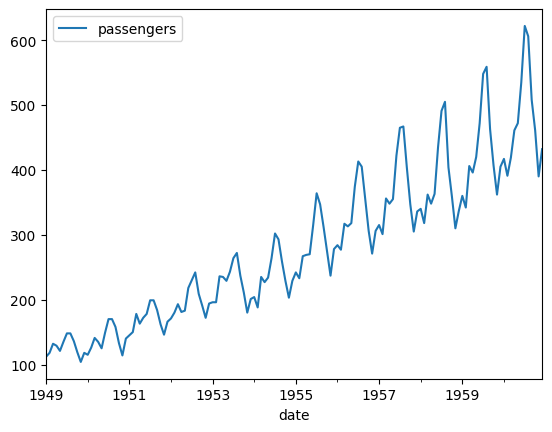

In [4]:
air_df.plot()

# Forecasting

[source](https://www.nbshare.io/notebook/136553745/Time-Series-Analysis-Using-ARIMA-From-StatsModels/),
[source](https://www.kaggle.com/code/prashant111/complete-guide-on-time-series-analysis-in-python)

Forecasting is about building models of the time series in order to predict values that are not part of the training set.

# Trend Forecasting

We start with trend forecasting.  We first extract the trend information from the time series by applying the rolling window methodology.

In [5]:
air_trend_df = air_df[['passengers']] \
  .rolling(12, min_periods=1) \
  .mean() \
  .set_axis(['trend'], axis=1)

<Axes: xlabel='date'>

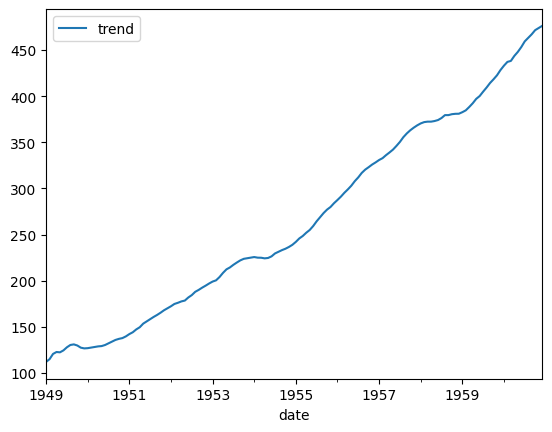

In [6]:
air_trend_df.plot()

## Linear Regression

We can't do linear regression with Pandas' DatetimeIndex objects as the independent variable.  Or for that matter, we cannot do linear regression with the original date string data.  Therefore, we create a new variable called **days** which simply **counts the number of days** from the start of the model data.  That new variable will become our independent variable as a proxy for the DatetimeIndex obects.  This is often called **feature engineering**.

In [7]:
model_df = air_trend_df.copy()
model_df['days'] = list((model_df.index - model_df.index[0]).days)
model_df.head()

,trend,days
date,,
1949-01-01,112.000000,0
1949-02-01,115.000000,31
1949-03-01,120.666667,59
1949-04-01,122.750000,90
1949-05-01,122.400000,120


In [8]:
from sklearn.linear_model import LinearRegression

model = LinearRegression()
model.fit(model_df[['days']],model_df['trend'])


LinearRegression()

<Axes: xlabel='date'>

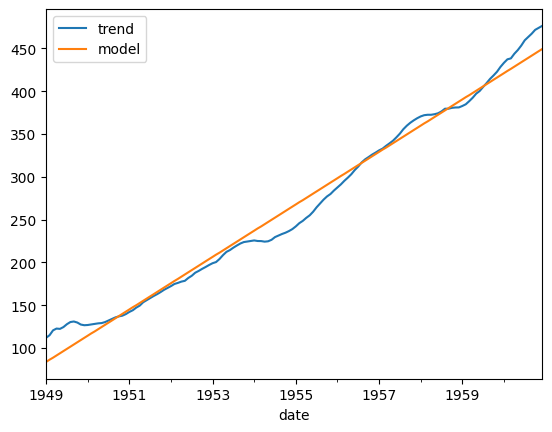

In [9]:
# visualize the fit
plot_df = pd.DataFrame({'trend':model_df['trend'],
                        'model':model.predict(model_df[['days']])})
plot_df.plot()

In [10]:
# compute the R^2 score
model.score(model_df[['days']],model_df['trend'])

0.9831801674640726

You might ask, why did we not do a linear regression on the original time series?  Surely, the linear regression would have fitted the overarching trend like so,

In [11]:
model_df2 = air_df.copy()
model_df2['days'] = list((model_df2.index - model_df2.index[0]).days)
model_df2.head()

,passengers,days
date,,
1949-01-01,112,0
1949-02-01,118,31
1949-03-01,132,59
1949-04-01,129,90
1949-05-01,121,120


In [12]:
model2 = LinearRegression()
model2.fit(model_df2[['days']],model_df2['passengers'])


LinearRegression()

<Axes: xlabel='date'>

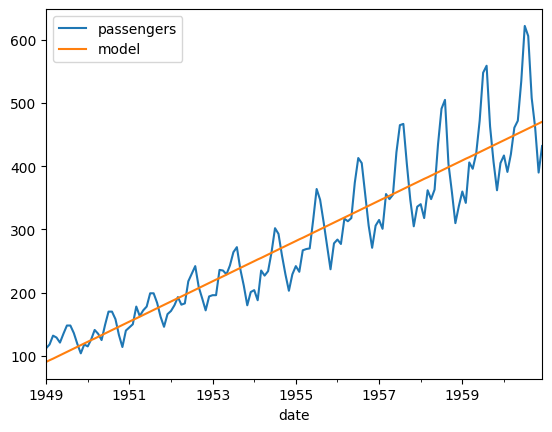

In [13]:
plot_df2 = pd.DataFrame({'passengers':model_df2['passengers'],
                        'model':model2.predict(model_df2[['days']])})
plot_df2.plot()

Ok, looks reasonable.  But here comes the big problem, the seasonal changes introduce large residuals and therefore we have a difficult time to ascertain how good our model acutally is with respect to the trend,

In [14]:
# compute the R^2 score
model2.score(model_df2[['days']],model_df2['passengers'])

0.8535045786367348

Looks good, but the $R^2$ score of our actual trend model was 0.98 and therefore an indicator that that model truly modeled the trend.

# Time Series Forecasting

Next we build models on the actual time series data.

## ARIMA

First we will use ARIMA (Autoregressive Integrated Moving Averages) models.  More precisely we will be using seaonal autoregressive integrated moving averages models or **SARIMA** due to the strong seaonal component in our time series.

### Testing for Stationarity

Before we can apply ARIMA we have to check for **stationarity** of our time series.  That is, we need to check whether the **mean and the variance is constant over time**.  In order to check this we split our time series into two time frames and check the mean and the variance in each of them.  If they are similar then we have a stationary time series, if not then we have a non-stationary time series.

In [15]:
split = air_df.shape[0] // 2
X1, X2 = air_df.iloc[:split,0], air_df.iloc[split:,0]
mean1, mean2 = X1.mean(), X2.mean()
var1, var2 = X1.var(), X2.var()
print('mean1={:.2f}, mean2={:.2f}'.format(mean1, mean2))
print('variance1={:.2f}, variance2={:.2f}'.format(var1, var2))


mean1=182.90, mean2=377.69
variance1=2275.69, variance2=7471.74


**Observation**: The mean and variance is substantially different in each of the time frames.  We have a **non-stationary** time series.

In order to fix this we let the ARIMA model perform **differencing** to turn the non-stationary time series into a stationary one.  This gives rise to **more accurate models**.

### The Model

In [16]:
from statsmodels.tsa.statespace.sarimax import SARIMAX

In [17]:
model3 = SARIMAX(
    air_df['passengers'],
    order=(1,1,0),            # differenced model
    seasonal_order=(0,1,0,12) # differenced seasonal model with period 12
)
fitted_model = model3.fit()

/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)
/usr/local/lib/python3.10/dist-packages/statsmodels/tsa/base/tsa_model.py:473: ValueWarning: No frequency information was provided, so inferred frequency MS will be used.
  self._init_dates(dates, freq)


<Axes: >

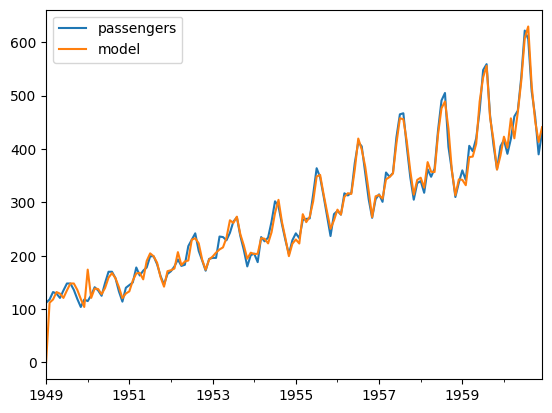

In [18]:
plot_df3 = pd.DataFrame({
    'passengers':air_df['passengers'],
    'model':fitted_model.predict()
})

plot_df3.plot()

The standard error metric for time series forecasts is the **mean absolute error** (MAE).  Let's compute it here.

In [19]:
from sklearn.metrics import mean_absolute_error

In [20]:
mean_absolute_error(plot_df3['passengers'],plot_df3['model'])

10.192828092301717

Let's compare this error to the error of the linear regression model we constructed earlier.

<Axes: xlabel='date'>

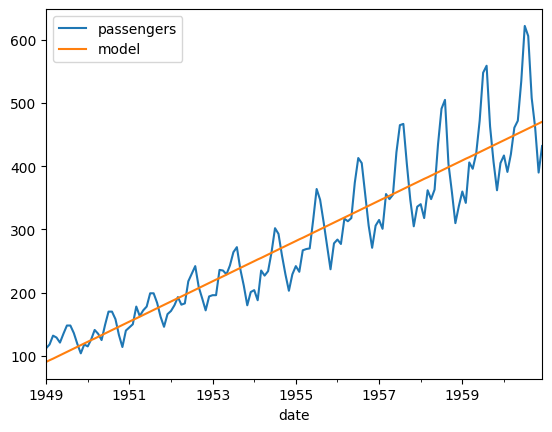

In [21]:
plot_df2.plot()

In [22]:
mean_absolute_error(plot_df2['passengers'],plot_df2['model'])

34.421954520312084

**Observation**: We obtain a much better model using ARIMA than, say, compated to a linear regression model.

## Gradient Boosting Regressor

Let's apply a machine learning model to this problem.  We use the gradient boosting regressor from sklearn.

In [23]:
from sklearn.ensemble import GradientBoostingRegressor

In [24]:
model_df2.head()

,passengers,days
date,,
1949-01-01,112,0
1949-02-01,118,31
1949-03-01,132,59
1949-04-01,129,90
1949-05-01,121,120


In [25]:
# we use the data we engineered for the linear regression (model_df2)
# as training data for our GBR
model4 = GradientBoostingRegressor(n_estimators=200)
model4.fit(model_df2[['days']],model_df2['passengers'])


GradientBoostingRegressor(n_estimators=200)

<Axes: xlabel='date'>

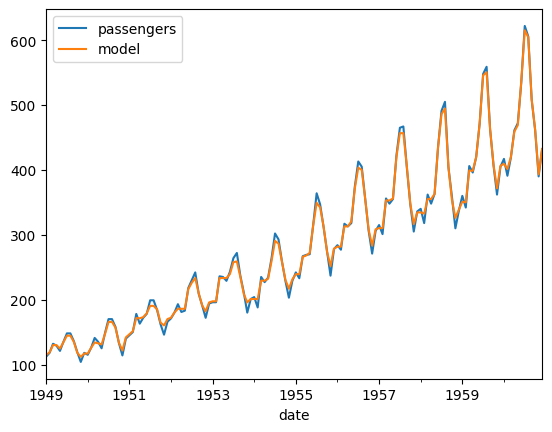

In [26]:
plot_df4 = pd.DataFrame({'passengers':model_df2['passengers'],
                         'model':model4.predict(model_df2[['days']])})
plot_df4.plot()

In [27]:
mean_absolute_error(plot_df4['passengers'],plot_df4['model'])

4.210777271817534

**Observation**: Our best model yet.  However, we need to worry whether or not we are starting to overfit. We can apply the standard ML technique of splitting the data into tain and test partitions and then try different fits of the boosted model.